In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
from src.data import load_characters, load_movies
from src.utils.helpers import (
    filter_by_country, 
    drop_nans, 
    fix_date, 
    filter_by_language, 
    merge_movies_and_actors
)

characters = load_characters()
characters = drop_nans(characters, column="FreebaseActorId")


movies = load_movies()

us_movies = filter_by_country(movies, country="United States of America")
print("Number of US movies:", us_movies.shape[0])


us_movies = drop_nans(us_movies, column="Revenue")
us_movies = drop_nans(us_movies, column="ReleaseDate")
us_movies = fix_date(us_movies, column="ReleaseDate")
print("Number of US movies after dropping Nans:", us_movies.shape[0])

us_movies = filter_by_language(us_movies, language="English Language")
us_characters_movies = merge_movies_and_actors(us_movies, characters)

Number of US movies: 34408
Number of US movies after dropping Nans: 6923


In [6]:
import networkx as nx
from src.utils.helpers import create_graph_from_data

G_US = create_graph_from_data(us_characters_movies)
print(f"Number of vertices: {len(G_US.nodes)}, number of edges: {len(G_US.edges)}")

Number of vertices: 30378, number of edges: 613672


#### Testing whether the biggest communities are stable

The result of the Louvian algorithm depends on the seed it is initialized with.
We will try to determine whether generated communities depend on the seed we use. To do that, we will consider multiple runs with $5$ different seeds.

For each ordered pair of runs we will match the communities of the first run to the communities of the second run. The matching procedure works like this:

Go over all communities in the run in the decreasing size order
1. For each community in the loop determine the community of the second run with the biggest intersection that wasn't yet picked
2. Mark the found community from the second run as picked

Using the information about matched communities, we will build a _matching graph_, where edges will be of the form $(i;j)$, where $i$ is the number of the run and $j$ is the community, we will draw a directed edge between $(i_{1};j_{1})$ and $(i_{2};j_{2})$ if the fraction of actors present in $(i_{1};j_{1})$ that is also present in $(i_{2};j_{2})$ is at least $0.8$, on the edge we will write this number.

If all the seeds produced the same result, we would get a set of complete graphs, of the form $\{(0;i), (1;i), \ldots, (5;i) \}$. But because different seeds produce different results, the subgraphs might be not complete. To determine stable communities, we will be looking for connected components that are "close to completeness": they have many edges between vertices.

In [306]:
from src.utils.helpers import read_communities

communities_US_list = []
communities_US_set_list = []
actor_id_to_community_list = []

for i in range(1, 6):
    communities_US = read_communities(G_US, f"data/processed/new_communities_US_{i}.json")
    communities_US = sorted(communities_US, key=lambda x: len(x), reverse=True)

    actor_id_to_community = dict()
    for i, community in enumerate(communities_US):
        for actor_id in community:
            actor_id_to_community[actor_id] = i

    actor_id_to_community_list.append(actor_id_to_community)
    communities_set_US = list(map(set, communities_US))
    communities_US_list.append(communities_US)
    communities_US_set_list.append(communities_set_US)

def map_communities(idx_i, idx_j):
    communities_i = communities_US_list[idx_i]
    communities_used_j = set()
    map_community = [-1 for _ in range(len(communities_i))]
    matching_percent = [0 for _ in range(len(communities_i))]
    for i, community in enumerate(communities_i):
        count_community = dict()
        for actor_id in community:
            other_community = actor_id_to_community_list[idx_j][actor_id]
            if other_community not in communities_used_j:
                count_community[other_community] = count_community.get(other_community, 0) + 1
        map_community[i] = max(count_community.items(), key=lambda x: x[1])[0] if len(count_community) > 0 else -1
        if map_community[i] != -1:
            matching_percent[i] = count_community[map_community[i]] / len(community)
            communities_used_j.add(map_community[i])
    return list(zip(map_community, matching_percent))


G = nx.DiGraph()
for i in range(5):
    for j in range(5):
         if i != j:
            mapping = map_communities(i, j)
            TAKE_CONST = 10
            for idx_from, stats_pair in enumerate(mapping[:TAKE_CONST]):
                from_v = f"{i};{idx_from}"
                to_v = f"{j};{stats_pair[0]}"
                if stats_pair[1] > 0.8: # int(idx_from) < TAKE_CONST and int(stats_pair[0]) < TAKE_CONST
                    G.add_edge(from_v, to_v, weight=round(stats_pair[1], 2))

Matching graph of the first $10$ communities

In [438]:
def draw_G(G, k=0.5, iterations=50, seed=1):
    pos=nx.spring_layout(G, k=k, iterations=iterations, seed=seed)
    nx.draw(G,pos, edge_cmap=plt.cm.Reds, with_labels=True)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)
    plt.show()

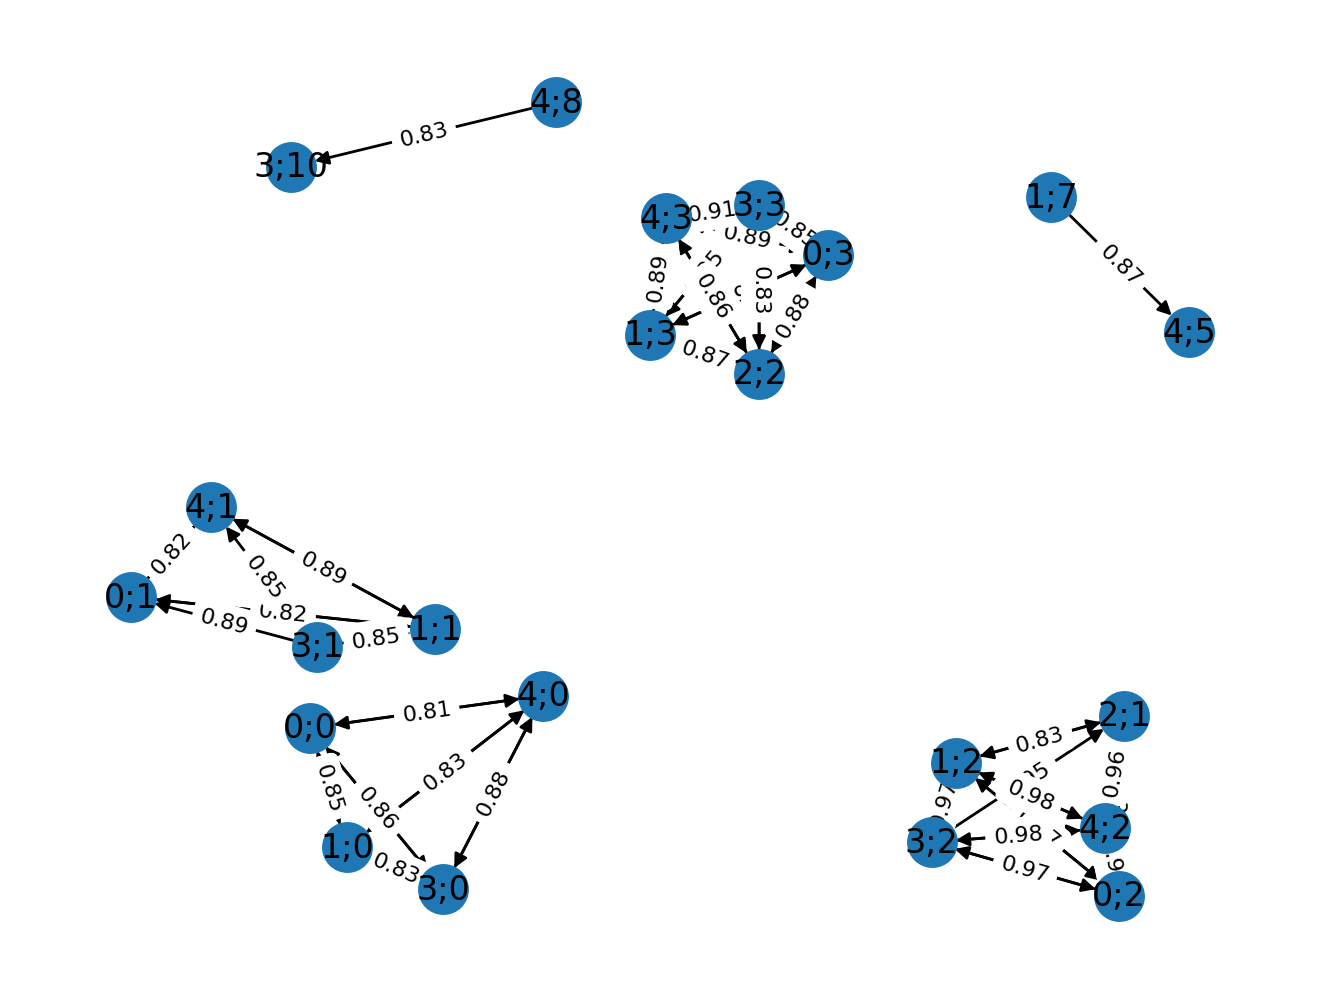

In [440]:
draw_G(G, k=0.5, iterations=30, seed=12)

We see that from the first 10 largest communities, only the first four (communities $0, 1, 2, 3$) are well grouped together. The indexing for communities $2$ and $3$ is not consistent (for example, we map $(0;2)$ to $(1;2)$).

We hypothize that this consistency means that actors in these communities are grouped better than in other ones

In [370]:
for i in range(5):
    print(list(map(len, communities_US_list[i]))[:6])

[6332, 5748, 4505, 3979, 1655, 643]
[6279, 6034, 4523, 3978, 642, 603]
[6687, 5214, 3975, 2237, 1461, 934]
[6734, 5036, 4308, 4249, 2088, 486]
[6799, 5897, 4260, 4140, 804, 662]


In [290]:
characters[characters["FreebaseActorId"].isin(communities_US_list[0][14])]

,WikipediaId,FreebaseId,ReleaseDate,CharacterName,ActorDateOfBirth,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAgeAtRelease,FreebaseCharacterActorMapId,FreebaseCharId,FreebaseActorId
4261,1597728,/m/05fggt,2004-02-05,Gino Donnini,1973-06-01,M,1.800,/m/047bp1r,Adam Garcia,30.0,/m/0220p12,/m/02nwhwr,/m/03hnhw
4616,6917005,/m/0gwypk,2003-02-16,Marian Paroo,1968-07-24,F,1.500,/m/0dbxy,Kristin Chenoweth,34.0,/m/04hv61q,/m/09j6068,/m/047c9l
4671,1853602,/m/0614yq,1986-01-17,Torok the Troll,1958-11-08,M,1.067,NaN,Phil Fondacaro,27.0,/m/0h5t_jt,/m/0hgx9pj,/m/0ksknr
4676,1853602,/m/0614yq,1986-01-17,Malcolm Mallory,1958-11-08,M,1.067,NaN,Phil Fondacaro,27.0,/m/0hgx9pz,/m/0hgx9q1,/m/0ksknr
4842,12509757,/m/048j2s,2002-02-18,Sister Madeline,1945-04-02,F,1.450,NaN,Linda Hunt,56.0,/m/0jxkfg,/m/0gz7jty,/m/02gz2p
...,...,...,...,...,...,...,...,...,...,...,...,...,...
447877,1873637,/m/062t9g,1958-02-18,NaN,1952-01-02,F,NaN,NaN,Marianne Leone Cooper,6.0,/m/0gc170n,NaN,/m/06ml5k
448155,2235410,/m/06y47p,1994,NaN,NaN,F,NaN,/m/0463n9y,Jackie Sawiris,NaN,/m/0gdnt5b,NaN,/m/0cc718_
448302,1246394,/m/04ltlj,1994-11-04,Dr. Henry Clerval,1953-12-06,M,1.702,NaN,Tom Hulce,40.0,/m/03l14py,/m/0b_wmvh,/m/016kdv
448911,454208,/m/02bg55,2004-01-23,Evan Treborn,1992-01-19,M,1.740,/m/041rx,Logan Lerman,12.0,/m/03jq21w,/m/04_8_ql,/m/04f1s6


In [422]:
from src.utils.actors import Cluster

stable_communities = [
    Cluster(characters, us_movies, communities_US_list[0][0]),
    Cluster(characters, us_movies, communities_US_list[0][1]),
    Cluster(characters, us_movies, communities_US_list[0][2]),
    Cluster(characters, us_movies, communities_US_list[0][3])
]

whole_us_industry = Cluster(characters, us_movies, [a for c in communities_US_list[3] for a in c])

In [426]:
def cluster_most_popular_genres(cluster, top_k=3):
    sorted_genres = sorted(cluster.cluster_genres().items(), key=lambda x: x[1], reverse=True)
    return sorted_genres[:top_k]

Let's find the most popular genres for each of the top communities.
In this section we will say that the film belongs to a cluster if at least half of the cast is in this cluster. This way each film will belong to at most one cluster.

In [427]:
for i, community in enumerate(stable_communities):
    print(f"For community {i} the top-3 genres are: {cluster_most_popular_genres(community)}")

For community 0 the top-3 genres are: [('Drama', 2333), ('Comedy', 2123), ('Thriller', 1363)]
For community 1 the top-3 genres are: [('Comedy', 1826), ('Drama', 1817), ('Thriller', 1032)]
For community 2 the top-3 genres are: [('Drama', 1117), ('Comedy', 859), ('Romance Film', 590)]
For community 3 the top-3 genres are: [('Drama', 1459), ('Comedy', 957), ('Thriller', 923)]


We see that the second one is a bit more about about comedy and the third one has more romance than thriller

In [437]:
us_num_actors_in_movie = dict(us_characters_movies.groupby("WikipediaId").size()) 

for i, community in enumerate(stable_communities):
    top_revenue_movies = community.cluster_movies(select_type="half", num_actors_in_movie=us_num_actors_in_movie).sort_values(by="Revenue", ascending=False)["MovieName"].head(30)
    print(f"For community {i}, the top grossing movies are: {top_revenue_movies.to_list()}")


For community 0, the top grossing movies are: ['Titanic', 'Toy Story 3', 'The Lion King', 'Finding Nemo', 'Jurassic Park', 'Independence Day', 'E.T. the Extra-Terrestrial', 'Up', 'Forrest Gump', 'Men in Black', 'The Simpsons Movie', 'Monsters, Inc.', 'Terminator 2: Judgment Day', 'Ghost', 'Aladdin', 'Toy Story 2', 'Home Alone', 'Pretty Woman', 'Tarzan', 'Mrs. Doubtfire', 'Beauty and the Beast', 'Dances with Wolves', 'Batman', 'The Bodyguard', 'Grease', 'Back to the Future', 'Godzilla', 'The Fugitive', 'Jurassic Park III', 'My Big Fat Greek Wedding']
For community 1, the top grossing movies are: ['Avatar', 'Shrek 2', 'Spider-Man 3', 'Ice Age: Dawn of the Dinosaurs', 'Ice Age: Continental Drift', 'Spider-Man', 'Shrek the Third', 'Spider-Man 2', 'Shrek Forever After', 'The Amazing Spider-Man', "Madagascar 3: Europe's Most Wanted", 'Mission: Impossible – Ghost Protocol', 'The Hunger Games', 'Ice Age: The Meltdown', 'Fast Five', 'Hancock', 'Men in Black 3', 'Iron Man 2', 'Madagascar: Escape

We see that if movies make up a series (like with Shrek, which has Shrek, Shrek 2, Shrek the Third, $\ldots$), then all the movies belong to one cluster. This is expected, because the movies in a series have similar casts.
Example of series from the highest-grossing movies:
- Community 0: Toy Story, Jurassic Park
- Community 1: Shrek, Spider-Man, Ice Age
- Community 2: - (films in this community are a bit more "romantic" as we have seen in the genre analysis and they don't tend to have continuations)
- Community 3: Harry Potter, The Lord of the Rings, The Dark Knight

In [479]:
G = nx.DiGraph()

for i in range(5):
    for j in range(5):
         if i != j:
            mapping = map_communities(i, j)
            TAKE_CONST = 25
            for idx_from, stats_pair in enumerate(mapping[:TAKE_CONST]):
                from_v = f"{i};{idx_from}"
                to_v = f"{j};{stats_pair[0]}"
                if stats_pair[1] > 0.8: # int(idx_from) < TAKE_CONST and int(stats_pair[0]) < TAKE_CONST
                    G.add_edge(from_v, to_v, weight=round(stats_pair[1], 2))

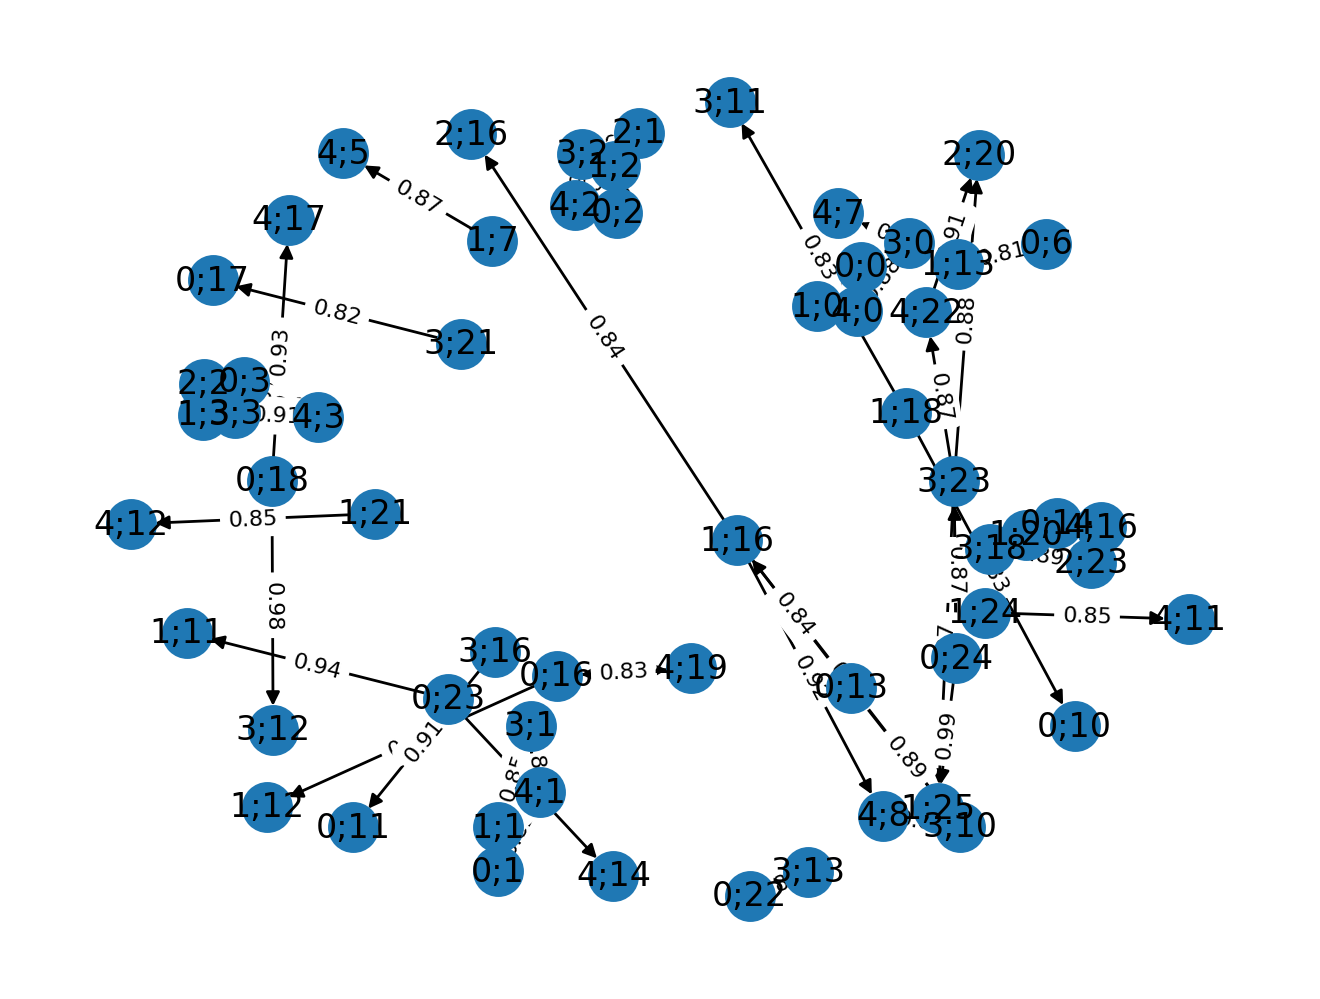

In [480]:
draw_G(G, k=0.2, iterations=30, seed=1)

In [474]:
interesting_clusters = [
    Cluster(characters, us_movies, communities_US_list[0][28]),
    Cluster(characters, us_movies, communities_US_list[0][23]),
    Cluster(characters, us_movies, communities_US_list[0][27]),
    Cluster(characters, us_movies, communities_US_list[0][18]),
]

In [475]:
interesting_clusters[1].cluster_movies(select_type="half", num_actors_in_movie=us_num_actors_in_movie).sort_values(by="Revenue", ascending=False)["MovieName"].head(30)

73924                         The Santa Clause
24838                       The Santa Clause 2
22501    The Santa Clause 3: The Escape Clause
47410                             The Good Son
42282        American Pie Presents: Beta House
74625                                     Zoom
32270                                     Prom
73990                            Away From Her
6618                              How She Move
Name: MovieName, dtype: object

In [476]:
from src.utils.networkx_helpers import katz_centrality
from src.utils.actors import ActorStats

interesting_cluster = interesting_clusters[1]

G_cluster = G_US.subgraph(interesting_cluster.actor_ids)
actor_stats = ActorStats(characters, us_movies)

nx.set_node_attributes(G_cluster, 
                       dict([(actor_id, actor_stats.actor_name(actor_id)) for actor_id in G_cluster.nodes()]),
                       'Name')
_ = katz_centrality(G_cluster)

Wendy Crewson has katz-centrality: 0.161
Tim Allen has katz-centrality: 0.147
Eric Lloyd has katz-centrality: 0.145
Spencer Breslin has katz-centrality: 0.122
Liliana Mumy has katz-centrality: 0.119


Wendy Crewson is actually important to the community, because she played in all of the Santa Clause movies and The Good Son